# CSE527 Homework 4
**Due date: 11:59 pm EST on April 24, 2022 (Sun.)**

In this semester, we will use Google Colab for the assignments, which allows us to utilize resources that some of us might not have in their local machines such as GPUs. You will need to use your Stony Brook (*.stonybrook.edu) account for coding and Google Drive to save your results.

## Google Colab Tutorial
---
Go to https://colab.research.google.com/notebooks/, you will see a tutorial named "Welcome to Colaboratory" file, where you can learn the basics of using google colab.

Settings used for assignments: ***Edit -> Notebook Settings -> Runtime Type (Python 3)***.


## Description
---
This project is an introduction to deep learning tools for computer vision. You will design and train deep convolutional networks for scene recognition using [PyTorch](http://pytorch.org). You can visualize the
structure of the network with [mNeuron] (http://vision03.csail.mit.edu/cnn_art/index.html)

In Problem 1 of the project you will train a deep convolutional network from scratch to recognize scenes. The starter codes gives you methods to load data and display them. You will need to define a simple network architecture and add jittering, normalization, and regularization to increase recognition accuracy to 50, 60, or perhaps 70%. Unfortunately, we only have 2,400 training examples so it doesn't seem possible to train a network from scratch which outperforms hand-crafted features

For Problem 2 you will instead fine-tune a pre-trained deep network to achieve about 85% accuracy on the task. We will use the pretrained AlexNet network which was not trained to recognize scenes at all. 

These two approaches represent the most common approaches to recognition problems in computer vision today -- train a deep network from scratch if you have enough data (it's not always obvious whether or not you do), and if you cannot then instead fine-tune a pre-trained network.

There are 2 problems in this homework with a total of 120 points including 20 bonus points. Be sure to read **Submission Guidelines** below. They are important. For the problems requiring text descriptions, you might want to add a markdown block for that.

## Dataset
---
Save the [dataset(click me)](https://drive.google.com/open?id=1NWC3TMsXSWN2TeoYMCjhf2N1b-WRDh-M) into your working folder in your Google Drive for this homework. <br>
Under your root folder, there should be a folder named "data" (i.e. XXX/Surname_Givenname_SBUID/data) containing the images.
**Do not upload** the data subfolder before submitting on blackboard due to size limit. There should be only one .ipynb file under your root folder Surname_Givenname_SBUID.

## Some Tutorials (PyTorch)
---
- You will be using PyTorch for deep learning toolbox (follow the [link](http://pytorch.org) for installation).
- For PyTorch beginners, please read this [tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) before doing your homework.
- Feel free to study more tutorials at http://pytorch.org/tutorials/.
- Find cool visualization here at http://playground.tensorflow.org.




In [ ]:
# import packages here
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random 
import time
import gc # changed
import torch
import torchvision
import torchvision.transforms as transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# Mount your google drive where you've saved your assignment folder
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Set your working directory (in your google drive)
#   change it to your specific homework directory.
%cd '/content/gdrive/MyDrive/CV/Avula_SaiManikanta_114701486_hw4'
# %cd '/content/gdrive/MyDrive/cv/test/Avula_SaiManikanta_114701486_hw4'

/content/gdrive/.shortcut-targets-by-id/1RtoXUP6U2nsH_SNWH64JQWwcFtbidq6X/Avula_SaiManikanta_114701486_hw4


## Problem 0: Loading and Preprocessing data
---
(0 point) In this part, you are provided with a function that loads data into minibatches for training and testing in PyTorch. However, some preprocessing parts are missing. Your will need to implement them when doing Problem 1.

In [ ]:
#--------------------------------------------------
#    Load Training Data and Testing Data
#--------------------------------------------------


def set_random_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
set_random_seed(0)

class_names = [name[13:] for name in glob.glob('./data/train/*')]
class_names = dict(zip(range(len(class_names)), class_names))
print("class_names: %s " % class_names)

def load_dataset(path, img_size, num_per_class=-1, batch_size=16, shuffle=False,
           augment=False, is_color=False, zero_centered=False, augment_rotate =  False):    
    data = []
    labels = []    
    channel_num = 3 if is_color else 1
        
    # read images and resizing
    for id, class_name in class_names.items():
        print("Loading images from class: %s" % id)
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        if num_per_class > 0:
            img_path_class = img_path_class[:num_per_class]
        labels.extend([id]*len(img_path_class))
        for filename in img_path_class:
            if is_color:
                img = cv2.imread(filename)
            else:
                img = cv2.imread(filename, 0)
            
            # resize the image
            img = cv2.resize(img, img_size, cv2.INTER_LINEAR)
            
            if is_color:
                img = np.transpose(img, [2, 0, 1])
            
            # norm pixel values to [-1, 1]
            data.append(img.astype(np.float)/255*2-1)
            
    ##########--WRITE YOUR CODE HERE--##########
    # Data Augmentation 
    if augment: 
        # pass
      data += [cv2.flip(eachImg ,1) for eachImg in data]
      labels += labels


    if augment_rotate:
      
      data += [cv2.rotate(eachImg,cv2.ROTATE_90_COUNTERCLOCKWISE ) for eachImg in data]
      labels += labels

    ##########-------END OF CODE-------##########    
    
    ##########--WRITE YOUR CODE HERE--##########
    # Data Normalization
    if zero_centered:
        # pass

        data = [(eachImg - np.mean(eachImg)) for eachImg in data]

        
    ##########-------END OF CODE-------##########
         
    # randomly permute (this step is important for training)
    if shuffle:
        bundle = list(zip(data, labels))
        random.shuffle(bundle)
        data, labels = zip(*bundle)
    
    # divide data into minibatches of TorchTensors
    if batch_size > 1:
        batch_data = []
        batch_labels = []
         
        for i in range(int(len(data) / batch_size)):
            minibatch_d = data[i*batch_size: (i+1)*batch_size]
            minibatch_d = np.reshape(minibatch_d, (batch_size, channel_num, img_size[0], img_size[1]))
            batch_data.append(torch.from_numpy(minibatch_d))

            minibatch_l = labels[i*batch_size: (i+1)*batch_size]
            batch_labels.append(torch.LongTensor(minibatch_l))
        data, labels = batch_data, batch_labels 
    
    return zip(batch_data, batch_labels)

class_names: {0: 'Forest', 1: 'Coast', 2: 'Flower', 3: 'Bedroom', 4: 'LivingRoom', 5: 'Kitchen', 6: 'Office', 7: 'Street', 8: 'OpenCountry', 9: 'Mountain', 10: 'Store', 11: 'Highway', 12: 'InsideCity', 13: 'Industrial', 14: 'Suburb', 15: 'TallBuilding'} 


In [ ]:
# load data into size (64, 64)
img_size = (64, 64)
batch_size = 64 # training sample number per batch

# load training dataset
trainloader_small = list(load_dataset('./data/train/', img_size, batch_size=batch_size, shuffle=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size))
test_num = len(testloader_small)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

Loading images from class: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 37 minibatches (batch_size=64) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 6 minib

TallBuilding


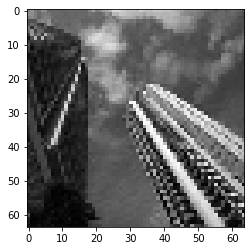

In [ ]:
# show some images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if len(npimg.shape) > 2:
        npimg = np.transpose(img, [1, 2, 0])
    plt.figure
    plt.imshow(npimg, 'gray')
    plt.show()
img, label = trainloader_small[0][0][11][0], trainloader_small[0][1][11]
label = int(np.array(label))
print(class_names[label])
imshow(img)

## Problem 1: Training a Network From Scratch
Gone are the days of hand designed features. Now we have end-to-end learning in which a highly non-linear representation is learned for our data to maximize our objective function (in this case, 16-way classification accuracy). Let's start!

First, let's define a simpe network architecture.

In [ ]:
#--------------------------------------------------
#       Define Network Architecture
#--------------------------------------------------
class TNet(nn.Module):
    def __init__(self):
      super(TNet,self).__init__()  
           
      self.features = torch.nn.Sequential(
        nn.Conv2d(1, 16, 3),
        nn.ReLU(),
        nn.MaxPool2d(4, stride=4), 
      )
      
      self.classifier = nn.Sequential(
         nn.Linear(3600, 16), 
      )
      
    def forward(self, x):
      x = self.features(x)  
      x = torch.flatten(x, 1)
      x = self.classifier(x)
      return x  
  

Then, let's define model training and evaluation functions.

In [ ]:
#--------------------------------------------------
#       Model Training Function
#--------------------------------------------------
import torch.optim as optim
import time
  
def trainModel(net, trainloader, train_option, testloader=None):  
  loss_func = nn.CrossEntropyLoss()
  lr = train_option['lr']
  epoch = train_option['epoch']
  device = train_option['device'] if 'device' in train_option.keys() else 'cpu'
  log_iter = train_option['log_iter'] if 'log_iter' in train_option.keys() else 20
  eval_epoch = 1
  
  if 'optimizer' in train_option.keys():
    optimizer = train_option['optimizer']
  else:
    optimizer = optim.Adam(net.parameters(), lr=lr)

  start_time = time.time()
  if device == 'gpu':
    net = net.cuda()
    
  iters = 0
  running_loss = 0.0
  for ep in range(epoch):
    net.train()        
    for iter, (x, y) in enumerate(trainloader):
      iters += 1
      batch_x = Variable(x).float()
      batch_y = Variable(y).long()
      if device == 'gpu':
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()

      outputs = net(batch_x)
      loss = loss_func(outputs, batch_y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      
      time_lapse = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))
      if iter % log_iter == 0:
        print('Epoch:{:2d} | Iter:{:5d} | Time: {} | Train Loss: {:.4f} | Average Loss: {:.4f} '.format(ep+1, iter, time_lapse, loss.item(), running_loss/iters))
   
    if testloader is not None and ep % eval_epoch == 0:
      evalModel(net, testloader)


In [ ]:
#--------------------------------------------------
#       Model Evaluating Function
#--------------------------------------------------
import time
  
def evalModel(net, testloader): 
  acc = 0.0
  count = 0
  start_time = time.time()
  device = 'gpu' if next(net.parameters()).is_cuda else 'cpu'
  net.eval()
  
  for iter, (x, y) in enumerate(testloader):
        count += x.shape[0]
        batch_x = Variable(x).float()
        batch_y = Variable(y).long()
        if device == 'gpu':
          batch_x = batch_x.cuda()
          batch_y = batch_y.cuda()
        outputs = net(batch_x)
        acc += torch.sum(outputs.max(1)[1]==batch_y)
        
  time_lapse = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))        
  print('Accuracy: {:5f} | Time: {}'.format(acc/count,time_lapse))
  

Finally, let's start training and evaluation.

In [ ]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------
net = TNet() 
train_option = {}
train_option['lr'] = 0.002
train_option['epoch'] = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_option['device'] = device
trainModel(net, trainloader_small, train_option, testloader_small)

del net
gc.collect()

Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.7883 | Average Loss: 2.7883 
Epoch: 1 | Iter:   20 | Time: 00:00:01 | Train Loss: 2.5512 | Average Loss: 2.6764 
Accuracy: 0.356771 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:01 | Train Loss: 1.6990 | Average Loss: 2.4497 
Epoch: 2 | Iter:   20 | Time: 00:00:02 | Train Loss: 2.0129 | Average Loss: 2.2529 
Accuracy: 0.424479 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:03 | Train Loss: 1.2755 | Average Loss: 2.1148 
Epoch: 3 | Iter:   20 | Time: 00:00:04 | Train Loss: 1.6448 | Average Loss: 1.9844 
Accuracy: 0.450521 | Time: 00:00:00
Epoch: 4 | Iter:    0 | Time: 00:00:05 | Train Loss: 1.0199 | Average Loss: 1.8805 
Epoch: 4 | Iter:   20 | Time: 00:00:06 | Train Loss: 1.3794 | Average Loss: 1.7786 
Accuracy: 0.455729 | Time: 00:00:00
Epoch: 5 | Iter:    0 | Time: 00:00:07 | Train Loss: 0.8368 | Average Loss: 1.6948 
Epoch: 5 | Iter:   20 | Time: 00:00:07 | Train Loss: 1.1768 | Average Loss: 1.6109 
Accuracy: 0.4661

2467

Great! You would get around 0.45-0.50 accuracy by this very simple network. Now it's your job to beat this result.

### Problem 1.1
(35 points) Try to boost the accuracy by doing the following steps:

**Data Augmentation**: We don't have enough training data, let's augment the training data.
If you **left-right flip (mirror) an image** of a scene, it never changes categories. A kitchen doesn't become a forest when mirrored. This isn't true in all domains — a "d" becomes a "b" when mirrored, so you can't "jitter" digit recognition training data in the same way. But we can synthetically increase our amount of training data by left-right mirroring training images during the learning process.

After you implement mirroring, you should notice that your training error doesn't drop as quickly. That's actually a good thing, because it means the network isn't overfitting to the 2,400 original training images as much (because it sees 4,800 training images now, although they're not as good as 4,800 truly independent samples). Because the training and test errors fall more slowly, you may need more training epochs or you may try modifying the learning rate. You are **required** to implement mirroring as data augmentation for this part.

You can try more elaborate forms of jittering -- zooming in a random amount, rotating a random amount, taking a random crop, etc. These are not required, you might want to try these in the bonus part.

**Data Normalization**: The images aren't **zero-centered**. One simple trick which can help a lot is to subtract the mean from every image. It would arguably be more proper to only compute the mean from the training images (since the test/validation images should be strictly held out) but it won't make much of a difference. This part is **required**.

**Network Regularization**: Add **dropout layer**. If you train your network (especially for more than the default 30 epochs) you'll see that the training error can decrease to zero while the val top1 error hovers at 40% to 50%. The network has learned weights which can perfectly recognize the training data, but those weights don't generalize to held out test data. The best regularization would be more training data but we don't have that. Instead we will use dropout regularization.

What does dropout regularization do? It randomly turns off network connections at training time to fight overfitting. This prevents a unit in one layer from relying too strongly on a single unit in the previous layer. Dropout regularization can be interpreted as simultaneously training many "thinned" versions of your network. At test, all connections are restored which is analogous to taking an average prediction over all of the "thinned" networks. You can see a more complete discussion of dropout regularization in this [paper](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf).

The dropout layer has only one free parameter — the dropout rate — the proportion of connections that are randomly deleted. The default of 0.5 should be fine. Insert a dropout layer between your convolutional layers. In particular, insert it directly before your last convolutional layer (and try others if that helps). Your train accuracy should decrease much more slowly. That's to be expected — you're making life much harder for the training algorithm by cutting out connections randomly. In this part, you are **required** to add dropout layer to your network.

**Please give detailed descriptions of your network layout in the following format:**<br>
Data augmentation: [descriptions]<br>
Data normalization: [descriptions]<br>
Layer 1: [layer_type]: [Parameters]<br>
Layer 2: [layer_type]: [Parameters]<br>
...<br>
**Then report the final accuracy on test set.**

The minimum accuracy required for this section is **0.55**.

In [ ]:
# load data into size (64, 64)
img_size = (64, 64)
batch_size = 64 # training sample number per batch

# load training dataset
trainloader_small = list(load_dataset('./data/train/', img_size, batch_size=batch_size, shuffle=True, augment=True, zero_centered=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size, zero_centered=True))
test_num = len(testloader_small)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

Loading images from class: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 75 minibatches (batch_size=64) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 6 minib

In [ ]:
#--------------------------------------------------
#       Define Network Architecture
#--------------------------------------------------
class TNet(nn.Module):
    def __init__(self):
      super(TNet,self).__init__()  
           
      self.features = nn.Sequential(
        nn.Conv2d(1, 32,  3),
        nn.ReLU(),
        nn.MaxPool2d(4, stride=4),
        # nn.Conv2d(1, 16,  3),
        # nn.ReLU(),
        # nn.MaxPool2d(4, stride=4),

      )
      
      self.classifier = nn.Sequential(
         nn.Linear(3600*2, 16), 
         nn.Dropout(0.5)
      )

      
    def forward(self, x):
      x = self.features(x)  
      x = torch.flatten(x, 1)
      x = self.classifier(x)
      return x  



In [ ]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------
net = TNet() 

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'gpu'
train_option = {'lr': 0.001, 'epoch': 40,  'device' : device}
trainModel(net, trainloader_small, train_option, testloader_small)

print(net, '1.1 network')
del net
gc.collect()

Epoch: 1 | Iter:    0 | Time: 00:00:08 | Train Loss: 2.7960 | Average Loss: 2.7960 
Epoch: 1 | Iter:   20 | Time: 00:00:08 | Train Loss: 2.7334 | Average Loss: 3.0180 
Epoch: 1 | Iter:   40 | Time: 00:00:08 | Train Loss: 2.4353 | Average Loss: 2.8294 
Epoch: 1 | Iter:   60 | Time: 00:00:08 | Train Loss: 2.3948 | Average Loss: 2.7033 
Accuracy: 0.377604 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:08 | Train Loss: 2.2864 | Average Loss: 2.6503 
Epoch: 2 | Iter:   20 | Time: 00:00:08 | Train Loss: 2.2261 | Average Loss: 2.5871 
Epoch: 2 | Iter:   40 | Time: 00:00:09 | Train Loss: 2.2387 | Average Loss: 2.5563 
Epoch: 2 | Iter:   60 | Time: 00:00:09 | Train Loss: 2.2939 | Average Loss: 2.5090 
Accuracy: 0.442708 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:09 | Train Loss: 2.0538 | Average Loss: 2.4813 
Epoch: 3 | Iter:   20 | Time: 00:00:09 | Train Loss: 2.1523 | Average Loss: 2.4441 
Epoch: 3 | Iter:   40 | Time: 00:00:09 | Train Loss: 2.0804 | Average Loss: 2.4150 
Epoc

108

**Answer**:

Data augmentation:  Every image is flipped around y-axis and augmented them to the dataset (Problem 0)

Data normalization: Every image is now zero-centered as I have subtracted mean of an images from the all the pixels in an individual image (Problem 0)

Layer 1: 32 Convolution filters of shape 3*3, stride 1 by default

Layer 2:  ReLU Activation 

Layer 3: Max Pooling of shape 4*4 with stride 4

Layer 4: Added a drop rate p = 0.5 (default)

Layer 5: A fully connected dense layer which has 3600*2 nodes as input and 16 nodes as output

...

Accuray on test set:  *57.5521 %* (Best - at 34th epoch)


## Problem 1.2

(15 points) Try **three different techniques** taught in the class to increase the accuracy of your model. Such as increasing training data by randomly rotating training images, adding batch normalization, different activation functions (e.g., sigmoid) and model architecture modification. Note that too many layers can do you no good due to insufficient training data. Clearly describe your method and accuracy increase/decrease for each of the three techniques.

The minimum accuracy required for this section is **0.60**. (At least one Technique should achieve this)

### Technique 1

In [ ]:
#--------------------------------------------------
#    Load Training Data and Testing Data
#--------------------------------------------------
# load data into size (64, 64)
img_size = (64, 64)
batch_size = 64 # training sample number per batch

# load training dataset
trainloader_small = list(load_dataset('./data/train/', img_size, batch_size=batch_size, shuffle=True, augment=True, zero_centered=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size, zero_centered=True))
test_num = len(testloader_small)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

Loading images from class: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 75 minibatches (batch_size=64) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 6 minib

In [ ]:
#--------------------------------------------------
#       Define Network Architecture
#--------------------------------------------------
class TNet(nn.Module):
    def __init__(self):
      super(TNet,self).__init__()  
           
      self.features = torch.nn.Sequential(
        # Layer 1
        nn.Conv2d(1, 32,  3),
        nn.ReLU(),
        #nn.Sigmoid()
        #nn.Tanh()
        nn.MaxPool2d(3, stride=3),


        # Layer 2
        nn.Conv2d(32, 16, 3), 
        nn.ReLU(),
        #nn.Sigmoid()
        #nn.Tanh()
        nn.MaxPool2d(3, stride=3),
        nn.Dropout(0.5)
      )
      
      self.classifier = nn.Sequential(
         nn.Linear(576, 212), 
         nn.Dropout(0.5),
         nn.Linear(212, 16) 
      )
      
    def forward(self, x):
      x = self.features(x)  
      x = torch.flatten(x, 1)
      x = self.classifier(x)
      return x  

In [ ]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------
net = TNet() 
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'gpu'
train_option = {'lr': 0.0005, 'epoch': 50,  'device' : device }
trainModel(net, trainloader_small, train_option, testloader_small)

print(net, '1.2 - (a) network')
del net
gc.collect()

Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.9123 | Average Loss: 2.9123 
Epoch: 1 | Iter:   20 | Time: 00:00:00 | Train Loss: 2.6430 | Average Loss: 2.7701 
Epoch: 1 | Iter:   40 | Time: 00:00:00 | Train Loss: 2.5578 | Average Loss: 2.6910 
Epoch: 1 | Iter:   60 | Time: 00:00:00 | Train Loss: 2.4116 | Average Loss: 2.6348 
Epoch: 1 | Iter:   80 | Time: 00:00:00 | Train Loss: 2.3983 | Average Loss: 2.5872 
Epoch: 1 | Iter:  100 | Time: 00:00:00 | Train Loss: 2.2489 | Average Loss: 2.5439 
Epoch: 1 | Iter:  120 | Time: 00:00:00 | Train Loss: 2.2904 | Average Loss: 2.5096 
Epoch: 1 | Iter:  140 | Time: 00:00:00 | Train Loss: 2.4857 | Average Loss: 2.4792 
Accuracy: 0.359375 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.1471 | Average Loss: 2.4654 
Epoch: 2 | Iter:   20 | Time: 00:00:01 | Train Loss: 2.1621 | Average Loss: 2.4337 
Epoch: 2 | Iter:   40 | Time: 00:00:01 | Train Loss: 2.1379 | Average Loss: 2.4080 
Epoch: 2 | Iter:   60 | Time: 00:00:01 |

154

**Answer**:

Technique 1: Model architecture modification ( more layers and different activation functions )

-> Added layer 2 of convolution and maxpooling to the first layer. Used ReLU activation here as well since using Sigmoid/Tanh activation decreases accuracy and increases computation time <br>
-> Also, added another dense layer of 212 neurons in the classifer part of the network <br>
-> Model converged slower (usually seen in networks with more hidden layers)

Accuracy on test set: *65.6250 * % (Best - at 47th epoch) 

Accuracy increases/decreases: Increased compared to original network

### Technique 2

In [ ]:
#--------------------------------------------------
#    Load Training Data and Testing Data
#--------------------------------------------------
# load data into size (64, 64)
img_size = (64, 64)
batch_size = 64 # training sample number per batch

# load training dataset
trainloader_small = list(load_dataset('./data/train/', img_size, batch_size=batch_size, shuffle=True, augment=True, zero_centered=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size, zero_centered=True))
test_num = len(testloader_small)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

Loading images from class: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 75 minibatches (batch_size=64) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 6 minib

In [ ]:
#--------------------------------------------------
#       Define Network Architecture
#--------------------------------------------------
class TNet(nn.Module):
    def __init__(self):
      super(TNet,self).__init__()  
           
      self.features = torch.nn.Sequential(
        nn.Conv2d(1, 16,  3),
        nn.LeakyReLU(),
        nn.MaxPool2d(3, stride=3),
        nn.BatchNorm2d(16),
        nn.Conv2d(16, 16, 3), 
        nn.LeakyReLU(),
        nn.MaxPool2d(3, stride=3),
        nn.BatchNorm2d(16),
        nn.Dropout(0.5)
      )
      
      self.classifier = nn.Sequential(
         nn.Linear(576, 212), 
         nn.Sigmoid(),
         nn.Dropout(0.5),
         nn.Linear(212, 16) 
      )
      
    def forward(self, x):
      x = self.features(x)  
      x = torch.flatten(x, 1)
      x = self.classifier(x)
      return x

In [ ]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------
net = TNet() 
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'gpu'
train_option = {'lr': 0.0005, 'epoch': 40,  'device' : device, 'loss': nn.CrossEntropyLoss}
trainModel(net, trainloader_small, train_option, testloader_small)

print(net, '1.2 - (b) network')
del net
gc.collect()

Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.8447 | Average Loss: 2.8447 
Epoch: 1 | Iter:   20 | Time: 00:00:00 | Train Loss: 2.5654 | Average Loss: 2.7312 
Epoch: 1 | Iter:   40 | Time: 00:00:00 | Train Loss: 2.5370 | Average Loss: 2.6410 
Epoch: 1 | Iter:   60 | Time: 00:00:00 | Train Loss: 2.2964 | Average Loss: 2.5719 
Accuracy: 0.372396 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.2118 | Average Loss: 2.5308 
Epoch: 2 | Iter:   20 | Time: 00:00:00 | Train Loss: 2.3164 | Average Loss: 2.4778 
Epoch: 2 | Iter:   40 | Time: 00:00:00 | Train Loss: 2.1822 | Average Loss: 2.4306 
Epoch: 2 | Iter:   60 | Time: 00:00:00 | Train Loss: 2.0119 | Average Loss: 2.3814 
Accuracy: 0.463542 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.0094 | Average Loss: 2.3472 
Epoch: 3 | Iter:   20 | Time: 00:00:01 | Train Loss: 1.9187 | Average Loss: 2.3018 
Epoch: 3 | Iter:   40 | Time: 00:00:01 | Train Loss: 1.9231 | Average Loss: 2.2610 
Epoc

108

**Answer**:

Technique 2:  More layers, better activation function as per our task, entropy loss function, Batch Normalization

-> Added layer 2 of convolution and maxpooling to the first layer. Used LeakyReLU activation here as well since using Sigmoid/Tanh activation decreases accuracy and increases computation time <br>
-> Also, added another dense layer of 212 neurons in the classifer part of the network <br>
-> Model converged slower (usually seen in networks with more hidden layers) <br>
-> Used LeakyReLU as activation for network layers in between and Sigmoid on the output layer (recommended for multiclass classification problem) - #Ref: https://towardsdatascience.com/comparison-of-activation-functions-for-deep-neural-networks-706ac4284c8a

Accuracy on test set: *69.2708%* (Best - 39th epoch)

Accuracy increases/decreases: Increased compared to original network

### Technique 3

In [ ]:
#--------------------------------------------------
#    Load Training Data and Testing Data
#--------------------------------------------------
# load data into size (64, 64)
img_size = (64, 64)
batch_size = 64 # training sample number per batch

# load training dataset
trainloader_small = list(load_dataset('./data/train/', img_size, batch_size=batch_size, shuffle=True, augment=True, zero_centered=True, augment_rotate=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size, zero_centered=True))
test_num = len(testloader_small)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

Loading images from class: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 150 minibatches (batch_size=64) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 6 mini

In [ ]:
#--------------------------------------------------
#       Define Network Architecture
#--------------------------------------------------
class TNet(nn.Module):
    def __init__(self):
      super(TNet,self).__init__()  
           
      self.features = torch.nn.Sequential(
        nn.Conv2d(1, 16,  3),
        nn.LeakyReLU(),
        nn.MaxPool2d(3, stride=3),
        nn.BatchNorm2d(16),
        nn.Conv2d(16, 16, 3), 
        nn.LeakyReLU(),
        nn.MaxPool2d(3, stride=3),
        nn.BatchNorm2d(16),
        nn.Dropout(0.5)
      )
      
      self.classifier = nn.Sequential(
         nn.Linear(576, 212), 
         nn.Sigmoid(),
         nn.Dropout(0.5),
         nn.Linear(212, 16) 
      )
      
    def forward(self, x):
      x = self.features(x)  
      x = torch.flatten(x, 1)
      x = self.classifier(x)
      return x

In [ ]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------

net = TNet() 
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'gpu'
train_option = {'lr': 0.0005, 'epoch': 40,  'device' : device, 'loss': nn.CrossEntropyLoss}
trainModel(net, trainloader_small, train_option, testloader_small)

print(net, '1.2 - (c) network')

del net
gc.collect()


Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.8135 | Average Loss: 2.8135 
Epoch: 1 | Iter:   20 | Time: 00:00:00 | Train Loss: 2.6298 | Average Loss: 2.7485 
Epoch: 1 | Iter:   40 | Time: 00:00:00 | Train Loss: 2.6109 | Average Loss: 2.6810 
Epoch: 1 | Iter:   60 | Time: 00:00:00 | Train Loss: 2.4752 | Average Loss: 2.6337 
Epoch: 1 | Iter:   80 | Time: 00:00:00 | Train Loss: 2.4285 | Average Loss: 2.5900 
Epoch: 1 | Iter:  100 | Time: 00:00:00 | Train Loss: 2.2554 | Average Loss: 2.5529 
Epoch: 1 | Iter:  120 | Time: 00:00:00 | Train Loss: 2.3375 | Average Loss: 2.5162 
Epoch: 1 | Iter:  140 | Time: 00:00:00 | Train Loss: 2.4106 | Average Loss: 2.4809 
Accuracy: 0.343750 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:01 | Train Loss: 2.2470 | Average Loss: 2.4664 
Epoch: 2 | Iter:   20 | Time: 00:00:01 | Train Loss: 2.2697 | Average Loss: 2.4331 
Epoch: 2 | Iter:   40 | Time: 00:00:01 | Train Loss: 2.1627 | Average Loss: 2.4024 
Epoch: 2 | Iter:   60 | Time: 00:00:01 |

108

**Answer**:

Technique 3:  More layers, better activation function as per our task, entropy loss function, Batch Normalization, More data augmentation with rotating the images by 90 degrees

-> Added layer 2 of convolution and maxpooling to the first layer. Used LeakyReLU activation here as well since using Sigmoid/Tanh activation decreases accuracy and increases computation time <br>
-> Also, added another dense layer of 212 neurons in the classifer part of the network <br>
-> Model converged slower (usually seen in networks with more hidden layers) <br>
-> Used LeakyReLU as activation for network layers in between and Sigmoid on the output layer (recommended for multiclass classification problem) - #Ref: https://towardsdatascience.com/comparison-of-activation-functions-for-deep-neural-networks-706ac4284c8a <br>
-> Augmented more data by rotating the images by 90 degrees
Accuracy on test set: 0.703125 (Best - 39th epoch)

Accuracy increases/decreases: *64.8438*% Increased compared to original network, but decreaded compared to other techniques

## Problem 2: Fine Tuning a Pre-Trained Deep Network
Our convolutional network to this point isn't "deep". Fortunately, the representations learned by deep convolutional networks is that they generalize surprisingly well to other recognition tasks. 

But how do we use an existing deep network for a new recognition task? Take for instance,  [AlexNet](http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks) network has 1000 units in the final layer corresponding to 1000 ImageNet categories.


**Hints**:
- Many pre-trained models are available in PyTorch at [here](http://pytorch.org/docs/master/torchvision/models.html).
- For fine-tuning pretrained network using PyTorch, please read this [tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).

### Problem 2.1

**Strategy A**: *Fine-tune* an existing network. In this scenario you take an existing network, replace the final layer (or more) with random weights, and train the entire network again with images and ground truth labels for your recognition task. You are effectively treating the pre-trained deep network as a better initialization than the random weights used when training from scratch. When you don't have enough training data to train a complex network from scratch (e.g. with the 16 classes) this is an attractive option. Fine-tuning can work far better than Strategy B of taking the activations directly from an pre-trained CNN. For example, in [this paper](http://www.cc.gatech.edu/~hays/papers/deep_geo.pdf) from CVPR 2015, there wasn't enough data to train a deep network from scratch, but fine tuning led to 4 times higher accuracy than using off-the-shelf networks directly.

(25 points) You are required to implement Strategy A to fine-tune a pre-trained **AlexNet** for this scene classification task. You should be able to achieve accuracy of **0.85** approximately. The minimum accuracy required for this section is **0.75**.

Please provide detailed descriptions of:<br>
(1) which layers of AlexNet have been replaced<br>
(2) the architecture of the new layers added including activation methods (same as problem 1)<br>
(3) the final accuracy on test set <br>

In [ ]:
# reload data with a larger size
img_size = (224, 224)
batch_size = 64 # training sample number per batch 

# load training dataset
# trainloader_large = list(load_dataset('./data/train/', img_size, batch_size=batch_size, shuffle=True, 
#                                       augment=True, is_color=True, zero_centered=True))
trainloader_large = list(load_dataset('./data/train/', img_size, num_per_class=100, batch_size=batch_size, shuffle=True, augment=True, is_color=True, zero_centered=True)) # changed
train_num = len(trainloader_large)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))
gc.collect()

# load testing dataset
testloader_large = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size, is_color=True, zero_centered=True))
test_num = len(testloader_large)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

Loading images from class: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 50 minibatches (batch_size=64) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 6 minib

In [ ]:
#--------------------------------------------------
#       Fine-Tune Pretrained Network
#--------------------------------------------------
AlexNet = torchvision.models.alexnet(pretrained=True)
# AlexNet.features[11] = nn.LeakyReLU()
AlexNet.classifier[1] = nn.Linear(9216, 2048)
AlexNet.classifier[2] = nn.LeakyReLU()
AlexNet.classifier[4] = nn.Linear(2048, 1024)
AlexNet.classifier[5] = nn.LeakyReLU()
AlexNet.classifier[6] = nn.Linear(1024,16)

print(AlexNet, '2.1 - network after modification')
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'gpu'
train_option = {'lr': 0.0001, 'epoch': 10,  'device' : device }# 'optimizer' : optim.SGD(AlexNet.parameters(), lr=0.01, momentum=0.9)}
trainModel(AlexNet, trainloader_large, train_option, testloader_large)

# del AlexNet
gc.collect()


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=2048, bias=True)
 

10

**Answer**:



Modifications:

(1) which layers of AlexNet have been replaced

Layers 1,2,4,5,6 of the alexnet model have been replaced

(2) the architecture of the new layers added including activation methods (same as problem 1)

Data augmentation:  Every image is flipped around y-axis and augmented them to the dataset (same as Problem 1)

Data normalization: Every image is now zero-centered as I have subtracted mean of an images from the all the pixels in an individual image (same as Problem 1)

Features Layers : No change in feature layers is done

Classifier Layer 1: A fully connected dense layer which has 9216 nodes as inputs and 2048 nodes as outputs + LeakyRelU activation

Classifier Layer 2: A fully connected dense layer which has 2048 nodes as inputs and 1024 nodes as outputs + LeakyRelU activation

Classifier Layer 3: A fully connected dense layer which has 1024 nodes as inputs and 16 nodes as outputs

...

(3) the final accuracy on test set

Pre-trained Alexnet model accuracy on test set after 10 epochs: *77.3438*%

Modified Alexnet model accuracy on test set after 10 epochs: *81.7708*%



### Problem 2.2
**Strategy B**: One could use those 1000 activations as a feature in place of a hand crafted feature such as a bag-of-features representation. You would train a classifier (typically a linear SVM) in that 1000 dimensional feature space. However, those activations are clearly very object specific and may not generalize well to new recognition tasks. It is generally better to use the activations in slightly earlier layers of the network, e.g. the 4096 activations in the last 2nd fully-connected layer. You can often get away with sub-sampling those 4096 activations considerably, e.g. taking only the first 1000 activations.

(25 points) Implement Strategy B where you use the activations of the pre-trained **AlexNet** as features to train **one-vs-all SVMs** for your scene classification task. Report the final accuracy on test set. You should be able to achieve accuracy of **0.80** approximately. The minimum accuracy required for this section is **0.70**.

In [ ]:
#--------------------------------------------------
#       Get Features from AlexNet
#--------------------------------------------------

def extract_features(model, numberOfFeatures, loader):
    features = []
    labels = []
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    for  (images, label) in loader:
      
        images, label = images.float().to(device), label.long().to(device)
        AlexNetImages = model(images)
        for index, img in enumerate(AlexNetImages):
            features.append(np.array(img[:numberOfFeatures].cpu().detach().numpy())) # Sub sampling only 1000 features
            labels.append(label[index].cpu().detach().numpy())        
    return np.array(features), np.array(labels)
    
def removeLastLayers(AlexNetNew):    
    AlexNetNew.classifier = nn.Sequential(*list(AlexNetNew.classifier.children())[:-2])
    return AlexNetNew

# AlexNetNew = torchvision.models.alexnet(pretrained=True)
AlexNetNew = AlexNet
print(AlexNetNew)
AlexNetNew = removeLastLayers(AlexNetNew) #Removes the last 2 layers of the classifier part of the network
print(AlexNetNew)
  
numberOfRequiredFeatures = 1000 # Features to extract after removing last 2 FC layers
trainFeatures, trainLabels = extract_features(AlexNetNew, numberOfRequiredFeatures, trainloader_large)
testFeatures, testLabels = extract_features(AlexNetNew, numberOfRequiredFeatures, testloader_large)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=2048, bias=True)
 

In [ ]:
#--------------------------------------------------
#       Train and Evaluate SVM
#--------------------------------------------------
from sklearn import svm
from sklearn.metrics import accuracy_score

svc = svm.LinearSVC(C=0.01, max_iter = 4000)
svc.fit(trainFeatures, trainLabels)

predictions = svc.predict(testFeatures)
accuracy = accuracy_score(testLabels, predictions)*100
print(f"Accuracy of AlexNet features and one-vs-all SVM on the test set: {accuracy:.5f} ")

gc.collect()
del  svc, trainFeatures, testFeatures, trainLabels, testLabels

Accuracy of AlexNet features and one-vs-all SVM on the test set: 82.03125 


**Answer**:

Accuracy on test set: *82.03125* %

### Problem 2.3 (Bonus)

(Bonus: 10 points) Bonus will be given to those who fine-tune the [ResNet network](https://pytorch.org/docs/stable/_modules/torchvision/models/resnet.html) [(paper)](https://arxiv.org/abs/1512.03385) and compare performance with AlexNet. Explain why ResNet performed better or worse. You are **required** to use **resnet50** model. You should be able to achieve accuracy of **0.99** approximately. The minimum accuracy required for this section is **0.85**.

In [ ]:
#--------------------------------------------------
#       Fine-Tune Pretrained Network
#--------------------------------------------------
gc.collect()

# print(torch.cuda.memory_summary(device=None, abbreviated=False))
# torch.cuda.empty_cache()

model = torchvision.models.resnet50(pretrained=True)
# print(model)
# model.relu  = nn.LeakyReLU()
model.fc = torch.nn.Sequential(
    torch.nn.Linear(
        in_features=2048,
        out_features=16                #since the last FC layer of resnet should have 16 output features
    ),
)

device = 'gpu'
train_option = {'lr': 0.0001, 'epoch': 10,  'device' : device }# 'optimizer' : optim.SGD(AlexNet.parameters(), lr=0.01, momentum=0.9)}
trainModel(model, trainloader_large, train_option, testloader_large)

Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.7445 | Average Loss: 2.7445 
Epoch: 1 | Iter:   20 | Time: 00:00:14 | Train Loss: 0.7495 | Average Loss: 1.5750 
Epoch: 1 | Iter:   40 | Time: 00:00:28 | Train Loss: 0.3987 | Average Loss: 1.0542 
Accuracy: 0.919271 | Time: 00:00:01
Epoch: 2 | Iter:    0 | Time: 00:00:36 | Train Loss: 0.2069 | Average Loss: 0.9021 
Epoch: 2 | Iter:   20 | Time: 00:00:50 | Train Loss: 0.1470 | Average Loss: 0.6895 
Epoch: 2 | Iter:   40 | Time: 00:01:04 | Train Loss: 0.0422 | Average Loss: 0.5540 
Accuracy: 0.932292 | Time: 00:00:01
Epoch: 3 | Iter:    0 | Time: 00:01:12 | Train Loss: 0.0263 | Average Loss: 0.5021 
Epoch: 3 | Iter:   20 | Time: 00:01:26 | Train Loss: 0.0141 | Average Loss: 0.4222 
Epoch: 3 | Iter:   40 | Time: 00:01:41 | Train Loss: 0.0129 | Average Loss: 0.3641 
Accuracy: 0.947917 | Time: 00:00:01
Epoch: 4 | Iter:    0 | Time: 00:01:49 | Train Loss: 0.0092 | Average Loss: 0.3405 
Epoch: 4 | Iter:   20 | Time: 00:02:03 | Train Loss:

**Answer**: Resnet performed better because it is more deep than Alexnet and has 50 layers on it => more paramters to tune. Also, Resnet architecture makes use of shortcut connections to solve vanishing gradients problem. Hence, any higher layer is bound to perform atleast as good as lower layers. However, Resnet needs more training time and computation power. additionally, a Resnet with full pre-activation performs better than Resnet50 ie., batch normaliztion and ReLU before addition layers.

Accuracy on test set: *94.0104* %


## Submission guidelines
---
Extract the downloaded .zip file to a folder of your preference. The input and output paths are predefined and **DO NOT** change them, (we assume that 'Surname_Givenname_SBUID_hw4' is your working directory, and all the paths are relative to this directory).  The image read and write functions are already written for you. All you need to do is to fill in the blanks as indicated to generate proper outputs. **DO NOT** zip and upload the dataset on blackboard due to size limit.

When submitting your .zip file through blackboard, please
-- name your .zip file as **Surname_Givenname_SBUID_hw*.zip**.

This zip file should include:
```
Surname_Givenname_SBUID_hw*
        |---Surname_Givenname_SBUID_hw*.ipynb
        |---Surname_Givenname_SBUID_hw*.pdf
```

For instance, student Yann LeCun should submit a zip file named "LeCun_Yann_111134567_hw4.zip" for homework4 in this structure:
```
LeCun_Yann_111134567_hw4
        |---LeCun_Yann_111134567_hw4.ipynb
        |---LeCun_Yann_111134567_hw4.pdf
```

The **Surname_Givenname_SBUID_hw*.pdf** should include a **google shared link**. To generate the **google shared link**, first create a folder named **Surname_Givenname_SBUID_hw*** in your Google Drive with your Stony Brook account. The structure of the files in the folder should be exactly the same as the one you downloaded. If you alter the folder structures, the grading of your homework will be significantly delayed and possibly penalized.

Then right click this folder, click ***Get shareable link***, in the People textfield, enter TA's email: ***kgarigapati@cs.stonybrook.edu***. Make sure that TAs who have the link **can edit**, ***not just*** **can view**, and also **uncheck** the **Notify people** box.

Colab has a good feature of version control, you should take advantage of this to save your work properly. However, the timestamp of the submission made in blackboard is the only one that we consider for grading. To be more specific, we will only grade the version of your code right before the timestamp of the submission made in blackboard. 

You are encouraged to post and answer questions on Piazza. Based on the amount of email that we have received in past years, there might be dealys in replying to personal emails. Please ask questions on Piazza and send emails only for personal issues.

Be aware that your code will undergo plagiarism check both vertically and horizontally. Please do your own work.

**Late submission penalty:** <br>
There will be a 10% penalty per day for late submission. However, you will have THREE days throughout the whole semester to submit late without penalty. Note that the grace period is calculated by days instead of hours. If you submit the homework one minute after the deadline, one late day will be counted. Likewise, if you submit one minute after the deadline, the 10% penaly will be imposed if not using the grace period.

<!--Write your report here in markdown or html-->
